In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('../data/processed/walmart.pkl')
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [17]:
store_34 = df[df['Store'] == 34][['Weekly_Sales']]
store_34.head()

,Weekly_Sales
Date,
2010-02-05,956228.96
2010-02-12,994610.99
2010-02-19,983963.07
2010-02-26,905756.13
2010-03-05,918295.79


In [7]:
#------------------------------------------------------------------------------------------------
# Selecting the p, d, q values by looping all possible combinations through an ARIMA model 
#------------------------------------------------------------------------------------------------

p = range(6)
q= range(6)
d = range(0,2)
pdq_val = list(itertools.product(p,d,q))

train = store_34.iloc[:110,:]['Weekly_Sales']
test = store_34.iloc[110:, :]['Weekly_Sales']

rmse = []
order = []

for pdq in pdq_val:
    model = ARIMA(train, order=pdq)
    model_fit = model.fit()
    preds = model_fit.predict(start=110, end=142)
    error = np.sqrt(mean_squared_error(test, preds))
    
    rmse.append(error)
    order.append(pdq)
    
error_df = pd.DataFrame({
    'Order':order,
    'RMSE': rmse,
    'r2_score': r2score
})
error_df.sort_values(by='RMSE', inplace=True)


In [5]:
#-----------------------------------------------------------------------------------------------------------
# Creating a Function to build an ARIMA model and plot the predictions
#-----------------------------------------------------------------------------------------------------------

def plot_arima(df, store_number: int, train_size:int, order=(1,1,1)):
    
    print("Select Store : ", store_number)
    
    store = df[df['Store'] == store_number][['Weekly_Sales']]
    
    resp = str(input("Do You want to view the Store Table: (y,n)")).lower()
    if resp == 'y':
        print(store)
        
        
    train_size = int(len(store)*train_size)
    
    train = store.iloc[:train_size]
    test = store.iloc[train_size:]
        
        
    model = ARIMA(store, order=order)
    model_fit = model.fit()
    preds = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
    
    
    
    print("Mean absolute Percentage error for the ARIMA model ", mean_absolute_percentage_error(test, preds))
    print('Root Mean Squared Error for the ARIMA model: ', np.sqrt(mean_squared_error(test, preds)))
    
    
    fig, ax = plt.subplots(2, 1, figsize=(15,10))


    test.plot(label='Test Sales', ax=ax[0], color='blue')
    preds.plot(label='Predicted Sales',ax=ax[0], color='red')
    ax[0].set_title(f'Predicted vs Actual Sales for ARIMA model of order {order}' )
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Weekly Sales')
    ax[0].legend()

    store.plot(label= 'Actual Sales', ax=ax[1], color='blue')
    preds.plot(label='Predicted Sales', ax=ax[1], color='red')
    ax[1].set_title(f'Actual Sales vs Predicted Sales for ARIMA model of order {order}'  )
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Weekly Sales')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
    

    
    return model_fit

Select Store :  34
Mean absolute Percentage error for the ARIMA model  0.025214472963397714
Root Mean Squared Error for the ARIMA model:  28893.247201344777


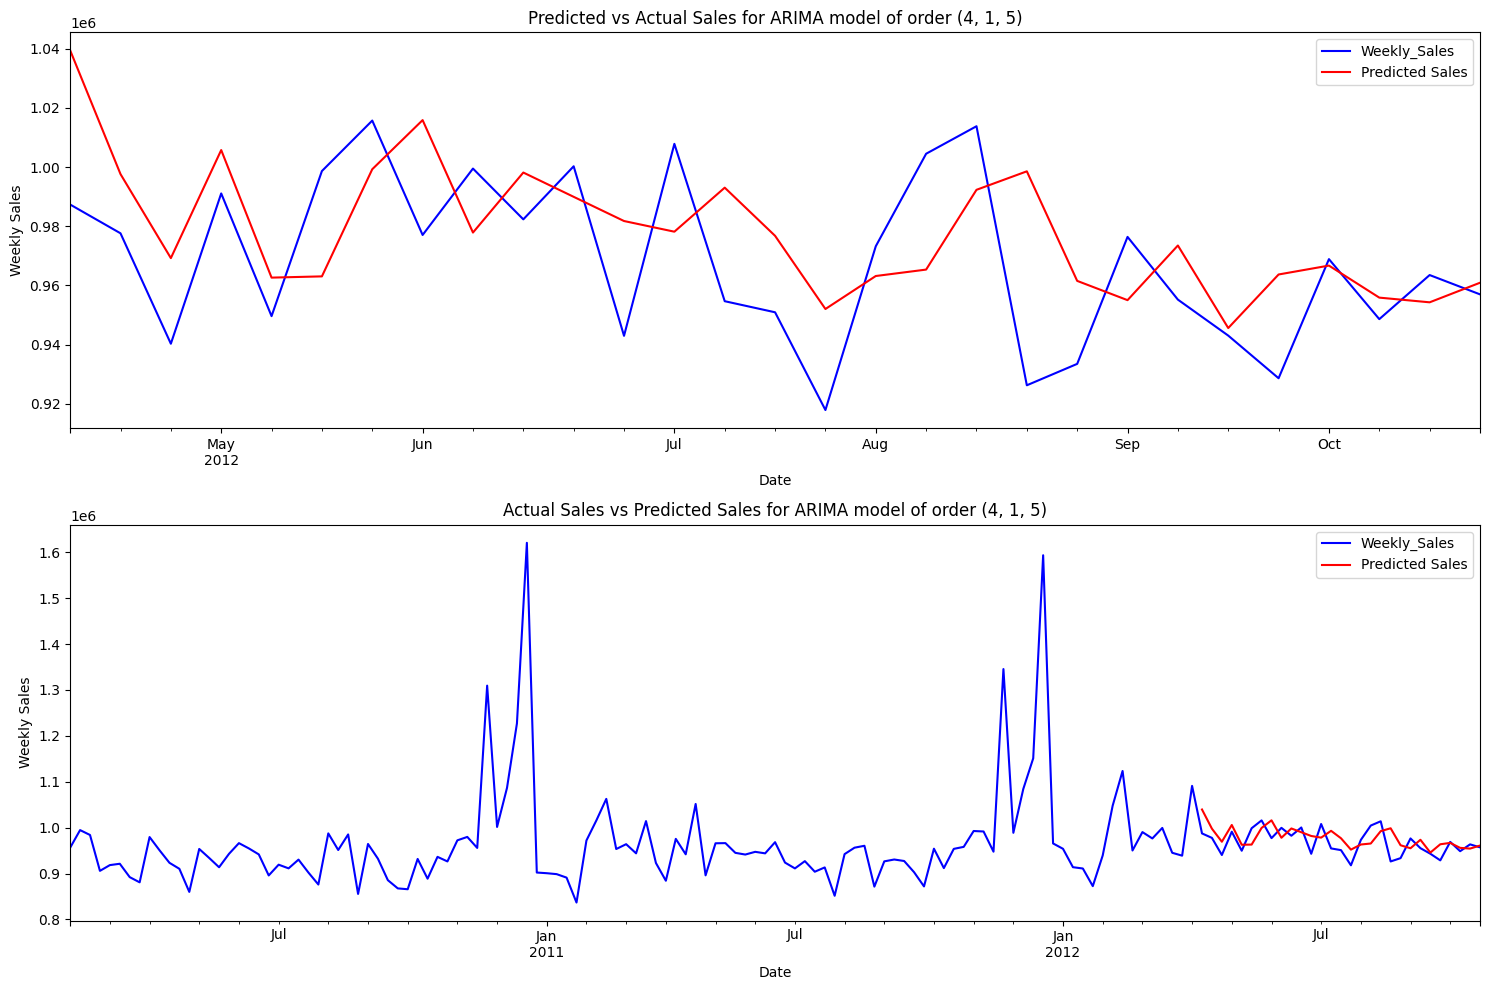

In [6]:
plot_arima(df=df, store_number=34, train_size=0.8, order=(4,1,5))

Select Store :  4
            Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44
...                  ...
2012-09-28    2027620.23
2012-10-05    2209835.43
2012-10-12    2133026.07
2012-10-19    2097266.85
2012-10-26    2149594.46

[143 rows x 1 columns]
Mean absolute Percentage error for the ARIMA model  0.027074034668517395
Root Mean Squared Error for the ARIMA model:  73551.26834009441


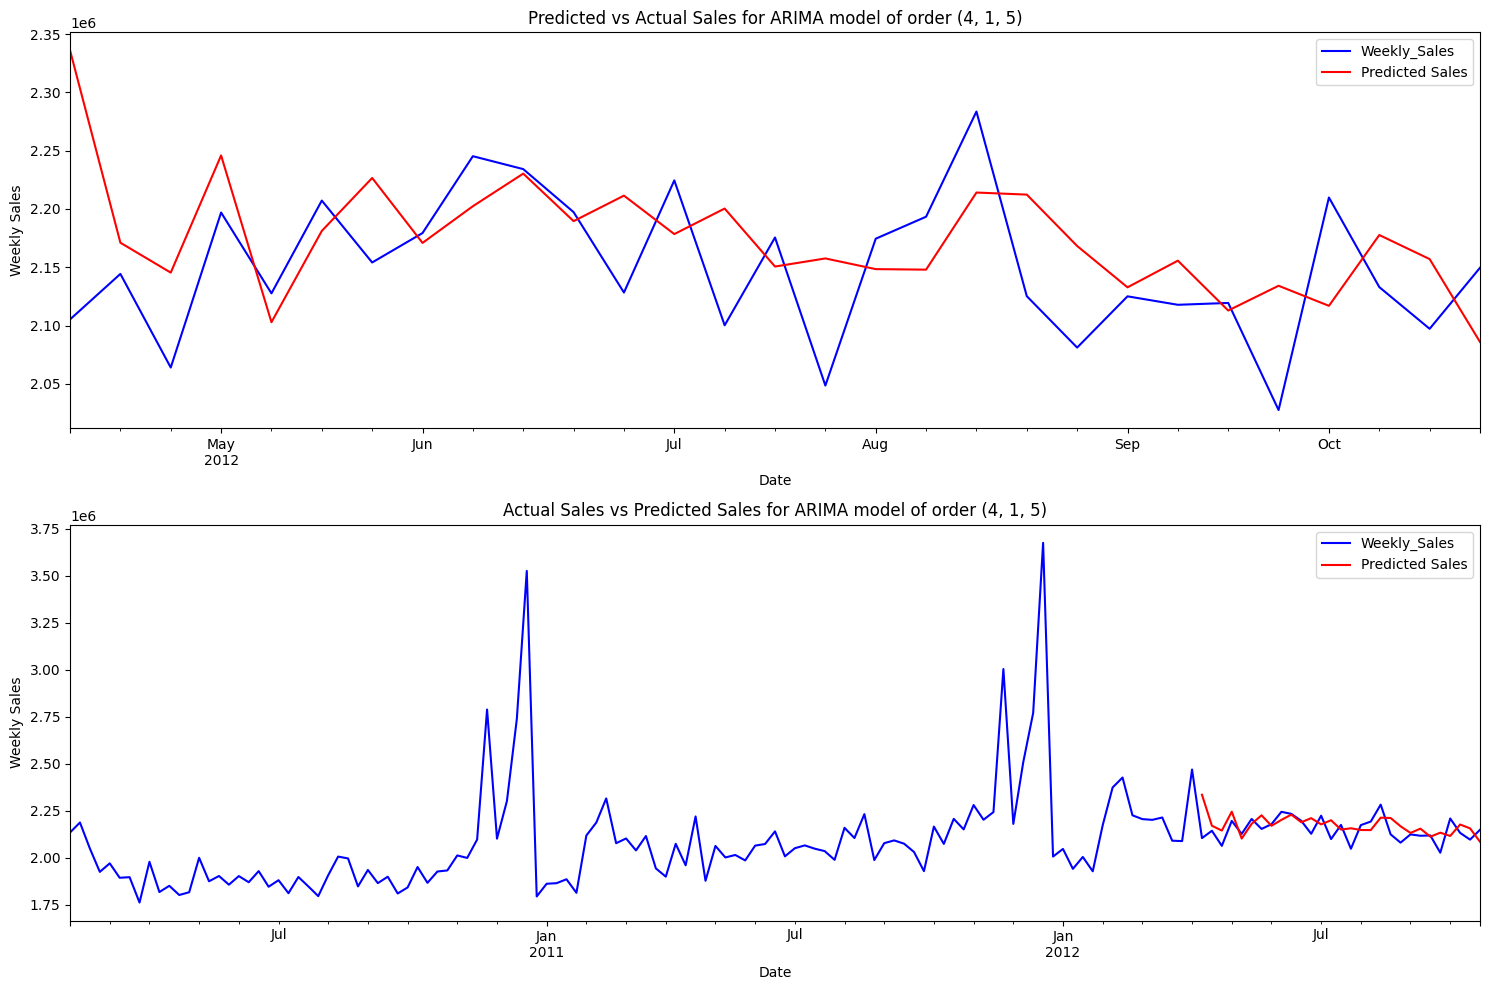

In [7]:
plot_arima(df=df, store_number=4, train_size=0.8, order=(4,1,5))

In [8]:
train = store_34.iloc[:110]
test = store_34.iloc[110:]
pdq=(4,1,5)
P = range(0,3)
D = range(0,3)
Q = range(0,3)
s = 52

seasonal_pdq_combination = list(itertools.product(P,D,Q,[s]))


In [10]:
error = []
mape= []
order = []
s_order = []


for seasonal_pdq in seasonal_pdq_combination:
    model = SARIMAX(store_34, order=pdq, seasonal_order=seasonal_pdq)
    model_fit = model.fit()
    preds = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
    
    rmse = np.sqrt(mean_squared_error(test, preds))
    mabs = mean_absolute_percentage_error(test, preds)
    
    error.append(rmse)
    mape.append(mabs)
    order.append(pdq)
    s_order.append(seasonal_pdq)
    
    
    print("Order : ", pdq)
    print('seasonal_order', seasonal_pdq )
        
result2_df = pd.DataFrame({
    'order': order, 
    'seasonal order': s_order,
    'rmse': error,
    'mape': mape
})

print(result2_df.sort_values(by='mape'))


Order :  (4, 1, 5)
seasonal_order (0, 0, 0, 52)
Order :  (4, 1, 5)
seasonal_order (0, 0, 1, 52)
Order :  (4, 1, 5)
seasonal_order (0, 0, 2, 52)
Order :  (4, 1, 5)
seasonal_order (0, 1, 0, 52)
Order :  (4, 1, 5)
seasonal_order (0, 1, 1, 52)
Order :  (4, 1, 5)
seasonal_order (0, 1, 2, 52)
Order :  (4, 1, 5)
seasonal_order (0, 2, 0, 52)
Order :  (4, 1, 5)
seasonal_order (0, 2, 1, 52)
Order :  (4, 1, 5)
seasonal_order (0, 2, 2, 52)
Order :  (4, 1, 5)
seasonal_order (1, 0, 0, 52)
Order :  (4, 1, 5)
seasonal_order (1, 0, 1, 52)
Order :  (4, 1, 5)
seasonal_order (1, 0, 2, 52)
Order :  (4, 1, 5)
seasonal_order (1, 1, 0, 52)
Order :  (4, 1, 5)
seasonal_order (1, 1, 1, 52)
Order :  (4, 1, 5)
seasonal_order (1, 1, 2, 52)
Order :  (4, 1, 5)
seasonal_order (1, 2, 0, 52)
Order :  (4, 1, 5)
seasonal_order (1, 2, 1, 52)
Order :  (4, 1, 5)
seasonal_order (1, 2, 2, 52)
Order :  (4, 1, 5)
seasonal_order (2, 0, 0, 52)
Order :  (4, 1, 5)
seasonal_order (2, 0, 1, 52)
Order :  (4, 1, 5)
seasonal_order (2, 0,

In [13]:
result2_df.sort_values(by='mape', inplace=True)
result2_df

result2_df.to_pickle('../New folder/data/Sarimax_coeff_scores2.pkl')

In [24]:
#-------------------------------------------------------------------------------------------
# Best Parameters for Sarimax Model 
#-------------------------------------------------------------------------------------------
result2_df.iloc[0]
order = result2_df.iloc[0][0]
seasonal_order = result2_df.iloc[0][1]

In [29]:
store_34 = df[df['Store'] == 34]['Weekly_Sales']

train = store_34.iloc[:110]
test = store_34.iloc[110:]
model = SARIMAX(store_34, order=(4,1,5), seasonal_order=(2,2,2,52))
model_fit = model.fit()

preds = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

<Axes: xlabel='Date'>

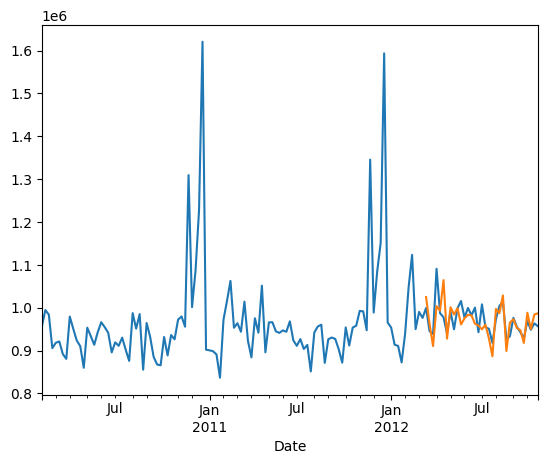

In [30]:
store_34.plot()
preds.plot()

In [32]:
forecast = model_fit.forecast(steps=12)

<Axes: xlabel='Date'>

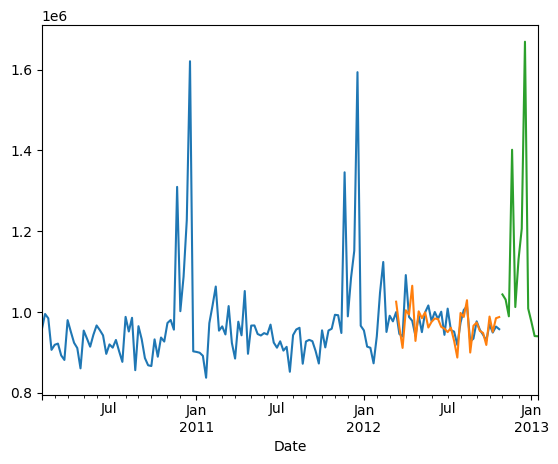

In [35]:
store_34.plot()
preds.plot()
forecast.plot()

In [49]:
forecast_df = pd.DataFrame(index=forecast.index, data=forecast.values, columns=['Forecasted Sales'])

forecast_df

,Forecasted Sales
2012-11-02,1.043079e+06
2012-11-09,1.030218e+06
2012-11-16,9.888327e+05
2012-11-23,1.401452e+06
2012-11-30,1.011811e+06
2012-12-07,1.129536e+06
2012-12-14,1.205966e+06
2012-12-21,1.669095e+06
2012-12-28,1.008175e+06
2013-01-04,9.752254e+05


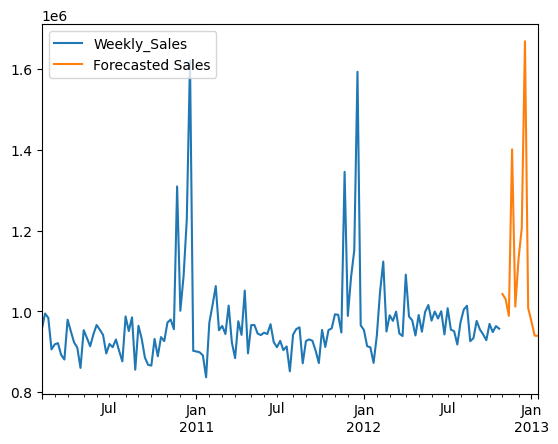

In [65]:
pd.concat([store_34, forecast_df], axis=1).plot()
plt.legend(loc='upper left')